## GSM8K

This notebook reproduces the results for the GSM8K evaluations

In [1]:
import json
import outlines
from tqdm import tqdm
import torch
from transformers import AutoTokenizer
from textwrap import dedent
from datasets import load_dataset
import re
from outlines.samplers import greedy

MODEL_NAME = "casperhansen/deepseek-r1-distill-qwen-7b-awq"
# Load the dataset from HuggingFace
dataset = load_dataset("gsm8k", "main")
# You can inspect the dataset structure
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 7473
    })
    test: Dataset({
        features: ['question', 'answer'],
        num_rows: 1319
    })
})


In [2]:
dataset['train']

Dataset({
    features: ['question', 'answer'],
    num_rows: 7473
})

In [3]:
all_evals = list(dataset['test'])
print(len(all_evals))

1319


In [4]:
from pydantic import BaseModel, create_model
from vllm import LLM, SamplingParams
from outlines.models.vllm import adapt_tokenizer
from outlines.processors import JSONLogitsProcessor

llm = LLM(MODEL_NAME, enable_prefix_caching=True)
tokenizer = llm.get_tokenizer()
outlines_tokenizer = adapt_tokenizer(AutoTokenizer.from_pretrained(MODEL_NAME))

INFO 01-28 10:09:44 config.py:510] This model supports multiple tasks: {'score', 'reward', 'classify', 'generate', 'embed'}. Defaulting to 'generate'.
INFO 01-28 10:09:45 awq_marlin.py:109] The model is convertible to awq_marlin during runtime. Using awq_marlin kernel.
WARNING 01-28 10:09:45 arg_utils.py:1103] Chunked prefill is enabled by default for models with max_model_len > 32K. Currently, chunked prefill might not work with some features or models. If you encounter any issues, please disable chunked prefill by setting --enable-chunked-prefill=False.
INFO 01-28 10:09:45 config.py:1458] Chunked prefill is enabled with max_num_batched_tokens=2048.
INFO 01-28 10:09:45 llm_engine.py:234] Initializing an LLM engine (v0.6.6.post1) with config: model='casperhansen/deepseek-r1-distill-qwen-7b-awq', speculative_config=None, tokenizer='casperhansen/deepseek-r1-distill-qwen-7b-awq', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


INFO 01-28 10:09:47 model_runner.py:1099] Loading model weights took 5.2282 GB
INFO 01-28 10:09:48 worker.py:241] Memory profiling takes 0.80 seconds
INFO 01-28 10:09:48 worker.py:241] the current vLLM instance can use total_gpu_memory (23.68GiB) x gpu_memory_utilization (0.90) = 21.31GiB
INFO 01-28 10:09:48 worker.py:241] model weights take 5.23GiB; non_torch_memory takes 0.24GiB; PyTorch activation peak memory takes 1.40GiB; the rest of the memory reserved for KV Cache is 14.44GiB.
INFO 01-28 10:09:48 gpu_executor.py:76] # GPU blocks: 16902, # CPU blocks: 4681
INFO 01-28 10:09:48 gpu_executor.py:80] Maximum concurrency for 131072 tokens per request: 2.06x
INFO 01-28 10:09:50 model_runner.py:1415] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utiliz

Capturing CUDA graph shapes: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:13<00:00,  2.67it/s]

INFO 01-28 10:10:04 model_runner.py:1535] Graph capturing finished in 13 secs, took 0.26 GiB
INFO 01-28 10:10:04 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 16.02 seconds


In [5]:
example_question = [
    "There are 15 trees in the grove. Grove workers will plant trees in the grove today. After they are done, there will be 21 trees. How many trees did the grove workers plant today?",
    "If there are 3 cars in the parking lot and 2 more cars arrive, how many cars are in the parking lot?",
    "Leah had 32 chocolates and her sister had 42. If they ate 35, how many pieces do they have left in total?"
]

In [6]:
# Note: `tokenizer.apply_chat_template` strips out the <think>...</think> when formatting messages, so these will be lost from the demos!
example_response = [
    """<think>There are 15 trees originally. Then there were 21 trees after some more were planted. So there must have been 21 - 15 = 6.</think>{"answer": 6}""",
    """<think>There are originally 3 cars. 2 more cars arrive. 3 + 2 = 5.</think>{"answer": 5}""",
    """<think>Originally, Leah had 32 chocolates. Her sister had 42. So in total they had 32 + 42 = 74. After eating 35, they had 74 - 35 = 39.</think>{"answer": 39}"""
]

In [7]:
# Note: the system message can contain the `<think>` and `</think>` tags and the tokenizer does not remove them when applying chat template
prompt_icl_messages = [
    {
        "role": "system",
        "content": dedent("""\
        You are an expert in solving grade school math tasks. You will be presented with a grade-school math word problem and be asked to solve it.
        Before answering you should reason about the problem (using the "reasoning" field in the JSON response described below).
          
        You will always respond with a thinking step followed immediately by JSON in the format described below:

        ```
        <think>Reasoning about the answer goes here</think>{"answer": "Final answer goes here"}
        ```

        The `<think>...</think>` section will contain your reasoning about the sequence of events.
        
        The JSON "answer" will contain the integer representing the correct answer to the question.
        """)
    },
]
for i, _ in enumerate(example_question):
    prompt_icl_messages.extend(
        [
            {"role": "user", "content": "Question: {question}".format(question=example_question[i])},
            {"role": "assistant", "content": example_response[i]},
        ]
    )

print(prompt_icl_messages)

[{'role': 'system', 'content': 'You are an expert in solving grade school math tasks. You will be presented with a grade-school math word problem and be asked to solve it.\nBefore answering you should reason about the problem (using the "reasoning" field in the JSON response described below).\n\nYou will always respond with a thinking step followed immediately by JSON in the format described below:\n\n```\n<think>Reasoning about the answer goes here</think>{"answer": "Final answer goes here"}\n```\n\nThe `<think>...</think>` section will contain your reasoning about the sequence of events.\n\nThe JSON "answer" will contain the integer representing the correct answer to the question.\n'}, {'role': 'user', 'content': 'Question: There are 15 trees in the grove. Grove workers will plant trees in the grove today. After they are done, there will be 21 trees. How many trees did the grove workers plant today?'}, {'role': 'assistant', 'content': '<think>There are 15 trees originally. Then there

In [8]:
def create_prompt(question, tokenizer):
    messages = list(prompt_icl_messages)
    messages.extend(
        [
            {"role": "user", "content": "Question: {question}".format(question=question)},
        ]
    )
    return tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

print(create_prompt(all_evals[5]['question'], tokenizer))

<｜begin▁of▁sentence｜>You are an expert in solving grade school math tasks. You will be presented with a grade-school math word problem and be asked to solve it.
Before answering you should reason about the problem (using the "reasoning" field in the JSON response described below).

You will always respond with a thinking step followed immediately by JSON in the format described below:

```
<think>Reasoning about the answer goes here</think>{"answer": "Final answer goes here"}
```

The `<think>...</think>` section will contain your reasoning about the sequence of events.

The JSON "answer" will contain the integer representing the correct answer to the question.
<｜User｜>Question: There are 15 trees in the grove. Grove workers will plant trees in the grove today. After they are done, there will be 21 trees. How many trees did the grove workers plant today?<｜Assistant｜>{"answer": 6}<｜end▁of▁sentence｜><｜User｜>Question: If there are 3 cars in the parking lot and 2 more cars arrive, how many

In [9]:
from pydantic import BaseModel, Field, constr
from outlines_core.fsm.json_schema import build_regex_from_schema
import json

class Response(BaseModel):
    answer: int = Field(pattern=r'[1-9][0-9]{0,9}')


schema_regex = build_regex_from_schema(json.dumps(Response.model_json_schema()))

In [10]:
all_evals[5]['question']

'Kylar went to the store to buy glasses for his new apartment. One glass costs $5, but every second glass costs only 60% of the price. Kylar wants to buy 16 glasses. How much does he need to pay for them?'

In [11]:
# temperature = 0 means greedy sampling
# https://docs.vllm.ai/en/stable/api/inference_params.html
from vllm import LLM, SamplingParams

def create_generator(llm: LLM, **sampling_kwargs):
    base_params = sampling_kwargs
    
    def generator(prompt: str, max_tokens: int = 2048):
        params = SamplingParams(
            **{**base_params, 'max_tokens': max_tokens}
        )
        outputs = llm.generate([prompt], params, use_tqdm=False)
        return outputs[0].outputs[0].text
    
    return generator

open_generator = create_generator(llm, temperature=0)

In [12]:
print(open_generator)

<function create_generator.<locals>.generator at 0x7fd5943363e0>


In [13]:
open_generator(create_prompt(all_evals[5]['question'], tokenizer),max_tokens=2560)

"<think>\nOkay, so Kylar wants to buy 16 glasses, and each glass normally costs $5. But every second glass is on sale for 60% of the original price. Hmm, I need to figure out how much he'll pay in total.\n\nFirst, I should understand the pricing structure. Every second glass is 60% off, which means it costs 60% of $5. Let me calculate that: 60% of $5 is 0.6 * 5 = $3. So, every even-numbered glass is $3, and the odd-numbered ones are $5.\n\nNow, Kylar is buying 16 glasses. Since every two glasses consist of one regular and one discounted, I can think of this as 8 sets of two glasses each. Each set has one $5 glass and one $3 glass.\n\nSo, for each set, the cost is $5 + $3 = $8. Since there are 8 sets, the total cost would be 8 * $8 = $64.\n\nWait, let me double-check. 16 glasses mean 8 regular and 8 discounted. 8 * $5 = $40, and 8 * $3 = $24. Adding those together: $40 + $24 = $64. Yep, that matches my earlier calculation.\n\nSo, Kylar needs to pay $64 in total.\n</think>\n\nKylar needs

In [14]:
re.search(schema_regex, create_prompt(all_evals[5]['question'], tokenizer))

<re.Match object; span=(879, 892), match='{"answer": 6}'>

## Unstructured Generation

In [15]:
LAST = len(all_evals)
answer_regex = r'"answer":[ ]?([1-9][0-9]{0,9})'
answers = []
for ex_eval in all_evals[0:LAST]:
    raw_int = ex_eval['answer'].split('#### ')[1]
    raw_int = re.sub(",","",raw_int)
    answers.append(int(raw_int))

In [16]:
free_resp = []
for i in tqdm(range(LAST), desc=f"Generating {LAST} evals"):
    free_resp.append(open_generator(create_prompt(all_evals[i]['question'], tokenizer), max_tokens=2560))


Generating 1319 evals: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1319/1319 [1:21:14<00:00,  3.70s/it]


In [17]:
free_resp[2]

"<think>\nFirst, I need to determine the total cost of the house by adding the purchase price and the repair costs. The house costs $80,000, and the repairs cost $50,000, so the total investment is $130,000.\n\nNext, the house's value increased by 150%. To find the increase in value, I calculate 150% of $130,000, which is $195,000.\n\nFinally, to find the profit, I subtract the total investment from the increased value. So, $195,000 minus $130,000 equals a profit of $65,000.\n</think>\n\nTo determine the profit Josh made, follow these steps:\n\n1. **Calculate the Total Investment:**\n   - **Purchase Price:** $80,000\n   - **Repair Costs:** $50,000\n   - **Total Investment:** $80,000 + $50,000 = **$130,000**\n\n2. **Determine the Increase in House Value:**\n   - The house's value increased by **150%** of the total investment.\n   - **Increase in Value:** 150% of $130,000 = 1.5 × $130,000 = **$195,000**\n\n3. **Calculate the Profit:**\n   - **Profit:** Increase in Value - Total Investmen

In [18]:
free_resp[3]

'<think>\nOkay, so I need to figure out how many meters James runs in a week. Let me break this down step by step. \n\nFirst, the problem says James runs 3 sprints 3 times a week. That means he\'s doing 3 sprints each day for 3 days. So, the total number of sprints he runs in a week is 3 sprints multiplied by 3 times, which is 3 * 3 = 9 sprints in total.\n\nNext, each sprint is 60 meters long. So, for each sprint, he covers 60 meters. To find out the total meters he runs in a week, I need to multiply the number of sprints by the distance per sprint. That would be 9 sprints * 60 meters per sprint.\n\nLet me do the multiplication: 9 * 60. Hmm, 9 times 60 is 540. So, James runs a total of 540 meters in a week.\n</think>\n\nJames runs 3 sprints 3 times a week, totaling 9 sprints. Each sprint is 60 meters, so the total meters he runs in a week are 9 * 60 = 540 meters.\n\n{"answer": 540}'

In [19]:
free_resp[4]

"<think>\nFirst, I need to determine how much feed each chicken receives per day. Wendi feeds each chicken three cups of mixed chicken feed daily.\n\nNext, I'll calculate the total daily feed consumption by multiplying the number of chickens by the amount of feed each chicken gets. So, 20 chickens multiplied by 3 cups equals 60 cups of feed per day.\n\nThen, I'll add up the feed given in the morning and afternoon meals. The morning meal is 15 cups, and the afternoon meal is 25 cups, totaling 40 cups.\n\nFinally, I'll subtract the total feed given in the morning and afternoon from the daily total to find out how much feed is needed for the final meal. So, 60 cups minus 40 cups equals 20 cups for the final meal.\n</think>\n\nTo determine how many cups of feed Wendi needs to give her chickens in the final meal, follow these steps:\n\n1. **Calculate the total daily feed consumption:**\n   - Each chicken is fed 3 cups per day.\n   - There are 20 chickens.\n   - Total daily feed = 20 chicken

In [20]:
free_resp_answers = [int(result[1].upper()) if result else "" for result in [re.search(answer_regex,resp) for resp in free_resp]]

In [21]:
print(free_resp_answers)

[18, 3, '', 540, '', '', '', 120, 45, '', 366, '', 12, 18, '', '', 230, '', 7, 6, 15, '', '', 8, 26, 2, '', 16, '', 104, 109, 80, '', 70, 23, 9, 75, 2, '', '', '', 200, 26, '', 20, '', 39, 800, 8, 30, '', 5, 15, 40, 30, 14, 3, 83, 57, 187, '', '', 75000, '', 300, 36, 48, 595, 36, 60, '', 60, '', '', 88, 18, 5, '', 6, '', '', 17, 623, 600, 15, 44, 22, 9583, '', '', 225, 28, '', 36, 348, 40, 3, 12, 5, 58, 175, 6, 26, 140, 500, 20, 72, 3, 50, '', 45, 16, 24, 25, 6, '', '', '', '', 86769, '', 27, 48, 50, 10, '', 82, 120, '', '', 30, '', 60, 13, '', 40, 6, '', 105, 70, 20, 400, '', 15, '', 4000, 2125, 45, 30, '', 4, '', 4, 48, 112, 280, 1400, 80, 34, 15, 16, 32, '', 50, 15, 77, 5, 16, 18, 120, 150, 1210, 51, 18000, 95, '', 100, '', '', 130, '', 160, 24, 2, 25, 30, 6, 106, 50, 34, 360, 5, 91, 24, '', 12, 120, '', 320, 7500, '', '', 100, '', '', 98, '', '', 76, '', '', '', 5, '', 8, 44, '', 15, 45, '', 70, 90, 140, 20000, 180, 9, 33, 9, 1, '', 276000, 50, 75, 12, 21, '', '', 90, '', 280, 21, 

In [22]:
print(answers)

[18, 3, 70000, 540, 20, 64, 260, 160, 45, 460, 366, 694, 13, 18, 60, 125, 230, 57500, 7, 6, 15, 14, 7, 8, 26, 2, 243, 16, 25, 104, 109, 80, 35, 70, 23, 9, 75, 2, 10, 18, 8, 200, 26, 48, 20, 104, 163, 800, 8, 30, 294, 5, 15, 40, 40, 14, 3, 83, 57, 187, 17, 1430, 25000, 1596, 300, 36, 48, 595, 36, 60, 7425, 60, 221, 255, 88, 60, 5, 100, 6, 70, 10, 17, 623, 600, 15, 44, 22, 9360, 8000, 24, 225, 28, 4, 36, 348, 40, 3, 12, 5, 58, 175, 6, 26, 140, 500, 20, 72, 3, 50, 28, 45, 16, 24, 25, 6, 90, 42, 360, 4, 95200, 240, 27, 48, 50, 10, 10, 82, 120, 880, 10000, 30, 940, 60, 13, 720, 40, 6, 29, 105, 70, 20, 400, 140, 16, 20, 4000, 2125, 75, 30, 16, 4, 5, 4, 48, 272, 280, 1400, 80, 34, 15, 16, 32, 92, 50, 15, 77, 5, 16, 18, 120, 150, 1210, 51, 18000, 95, 15, 100, 350, 122, 130, 20, 160, 23, 2, 25, 30, 5, 106, 50, 34, 360, 5, 91, 24, 10, 12, 120, 6277, 320, 7500, 55, 114200, 100, 31, 98, 98, 860, 2600, 76, 145, 10, 4, 5, 250, 8, 44, 220, 15, 45, 54, 70, 90, 140, 20000, 180, 9, 33, 9, 1, 21, 276000,

In [23]:
import numpy as np
np.mean([result[0] == result[1] for result in zip(free_resp_answers, answers)])

0.6080363912054587

## Structured Generation

In [24]:
print(schema_regex)

\{[ ]?"answer"[ ]?:[ ]?(-)?(0|[1-9][0-9]*)[ ]?\}


In [25]:
bot, eot = "<think>", "</think>"


class StructuredAnswer(BaseModel):
    answer: int
    

class TriggerBasedLogitsProcessor:
    """Logits processor that triggers JSON generation after </think> token"""

    def __init__(self, tokenizer, base_processor, guide: type[BaseModel] = StructuredAnswer):
        self.tokenizer = tokenizer
        self.base_processor = base_processor
        self.guide = guide
        self.bot_id, self.eot_id = tokenizer.convert_tokens_to_ids([bot, eot])
        self.triggered = False
        self.triggered_at = -1
        self.in_cot = False
        self.history = []
        self.cot = ""

    def __call__(
        self, prompt: tuple[int], generated_tokens: tuple[int], logits: torch.Tensor
    ) -> torch.Tensor:
        if not self.in_cot and not self.cot:
            # We may be in the CoT if the BOT was in the prompt (but not EOT)
            self.in_cot = self.bot_id in prompt and self.eot_id not in prompt
            if self.in_cot:
                self.cot = self.tokenizer.decode(
                    prompt[prompt.index(self.bot_id) + 1 :]
                ).lstrip()
        if len(generated_tokens) > 0:
            last_id = generated_tokens[-1]
            if not self.in_cot:
                self.in_cot = last_id == self.bot_id
            if self.in_cot:
                is_eot = last_id == self.eot_id
                if is_eot:
                    self.triggered_at = len(generated_tokens)
                    self.triggered = True
                    self.in_cot = False
                    self.cot += self.tokenizer.decode(self.history).strip()
            self.history.append(last_id)

        # Only apply base processor if triggered
        if self.triggered:
            return self.base_processor(generated_tokens, logits)
        return logits

In [26]:
# structured_generator = outlines.generate.regex(model, schema_regex, sampler=greedy())

def structured_generator(prompt, guide = StructuredAnswer, temperature=0, max_new_tokens=2560):
    json_schema = json.dumps(guide.model_json_schema())
    model_name = llm.llm_engine.model_config.model
    tokenizer = llm.get_tokenizer()
    outlines_tokenizer = adapt_tokenizer(AutoTokenizer.from_pretrained(model_name))
    guided_processor = JSONLogitsProcessor(
        schema=json_schema, tokenizer=outlines_tokenizer, whitespace_pattern=r" ?"
    )
    conditional_guide_processor = TriggerBasedLogitsProcessor(
        tokenizer=outlines_tokenizer, base_processor=guided_processor, guide=guide
    )
    sampling_params = SamplingParams(
        temperature=temperature,
        max_tokens=max_new_tokens,
        logits_processors=[conditional_guide_processor],
    )
    # Generate output
    logits_processor = sampling_params.logits_processors[0]  # or conditional_guide_processor
    output = llm.generate(prompt, sampling_params, use_tqdm=False)
    generated_text = output[0].outputs[0].text
    cot = logits_processor.cot
    # JSON structured response here
    post_cot = tokenizer.decode(
        logits_processor.history[logits_processor.triggered_at :],
        skip_special_tokens=True,
    )
    structured = (
        '{"reasoning": "' + json.dumps(cot)[1:-1] + '", ' + post_cot.removeprefix("{")
    )
    return structured

In [27]:
structured_resp = [structured_generator(create_prompt(all_evals[i]['question'], tokenizer)) for i in tqdm(range(LAST))]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1319/1319 [1:22:40<00:00,  3.76s/it]


In [28]:
structured_resp[3]

'{"reasoning": "<think>\\nOkay, so I need to figure out how many meters James runs in a week. Let me break this down step by step. \\n\\nFirst, the problem says James runs 3 sprints 3 times a week. That means he\'s doing 3 sprints each day for 3 days. So, the total number of sprints he runs in a week is 3 sprints multiplied by 3 times, which is 3 * 3 = 9 sprints in total.\\n\\nNext, each sprint is 60 meters long. So, for each sprint, he covers 60 meters. To find out the total meters he runs in a week, I need to multiply the number of sprints by the distance per sprint. That would be 9 sprints * 60 meters per sprint.\\n\\nLet me do the multiplication: 9 * 60. Hmm, 9 times 60 is 540. So, James runs a total of 540 meters in a week.", "answer": 540}'

In [29]:
structured_resp_answers = [int(result[1].upper()) if result else "" for result in [re.search(answer_regex,resp) for resp in structured_resp]]
print(answers)

[18, 3, 70000, 540, 20, 64, 260, 160, 45, 460, 366, 694, 13, 18, 60, 125, 230, 57500, 7, 6, 15, 14, 7, 8, 26, 2, 243, 16, 25, 104, 109, 80, 35, 70, 23, 9, 75, 2, 10, 18, 8, 200, 26, 48, 20, 104, 163, 800, 8, 30, 294, 5, 15, 40, 40, 14, 3, 83, 57, 187, 17, 1430, 25000, 1596, 300, 36, 48, 595, 36, 60, 7425, 60, 221, 255, 88, 60, 5, 100, 6, 70, 10, 17, 623, 600, 15, 44, 22, 9360, 8000, 24, 225, 28, 4, 36, 348, 40, 3, 12, 5, 58, 175, 6, 26, 140, 500, 20, 72, 3, 50, 28, 45, 16, 24, 25, 6, 90, 42, 360, 4, 95200, 240, 27, 48, 50, 10, 10, 82, 120, 880, 10000, 30, 940, 60, 13, 720, 40, 6, 29, 105, 70, 20, 400, 140, 16, 20, 4000, 2125, 75, 30, 16, 4, 5, 4, 48, 272, 280, 1400, 80, 34, 15, 16, 32, 92, 50, 15, 77, 5, 16, 18, 120, 150, 1210, 51, 18000, 95, 15, 100, 350, 122, 130, 20, 160, 23, 2, 25, 30, 5, 106, 50, 34, 360, 5, 91, 24, 10, 12, 120, 6277, 320, 7500, 55, 114200, 100, 31, 98, 98, 860, 2600, 76, 145, 10, 4, 5, 250, 8, 44, 220, 15, 45, 54, 70, 90, 140, 20000, 180, 9, 33, 9, 1, 21, 276000,

In [30]:
import numpy as np
np.mean([result[0] == result[1] for result in zip(structured_resp_answers, answers)])

0.8400303260045489

Text(0.5, 1.0, 'GSM8K - Unstructured vs. JSON Structured\ncasperhansen/deepseek-r1-distill-qwen-7b-awq')

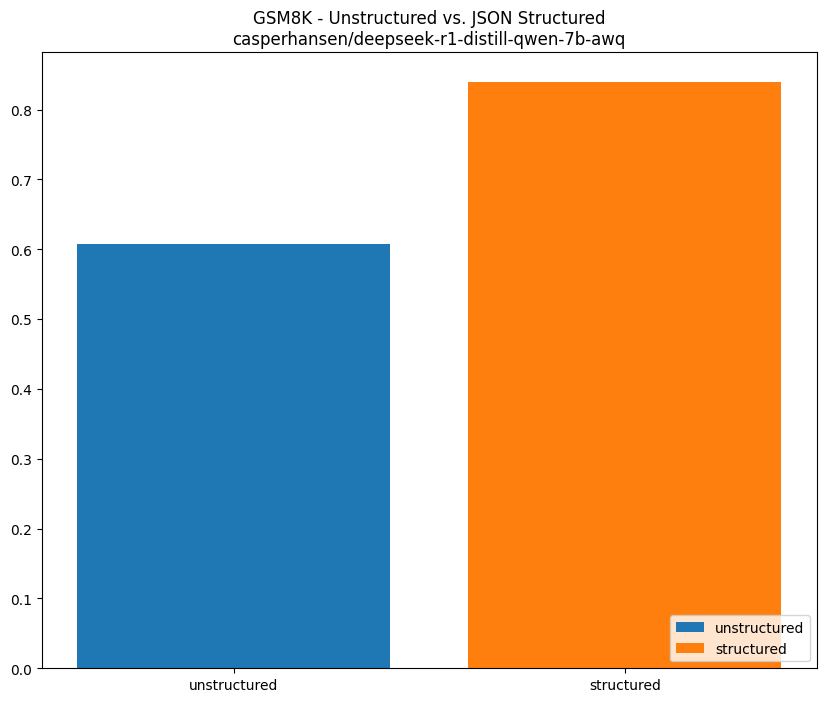

In [31]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,figsize=(10,8),facecolor='white')
ax.bar('unstructured',np.mean([result[0] == result[1] for result in zip(free_resp_answers, answers)]),label='unstructured')
ax.bar('structured',np.mean([result[0] == result[1] for result in zip(structured_resp_answers, answers)]),label='structured')
ax.legend(loc="lower right")
ax.set_title(f"GSM8K - Unstructured vs. JSON Structured\n{MODEL_NAME}")